In [68]:
import sys

assert sys.version_info >= (3, 7)

In [69]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [70]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [71]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [72]:
import numpy as np

In [93]:
# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [94]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

In [95]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

In [96]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 10

**Conv2D & MaxPooling2D**

In [77]:
inputs = tf.keras.layers.Input(shape=[28, 28, 1])
x = tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu", padding="same")(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu", padding="same")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
codings_mean = tf.keras.layers.Dense(codings_size)(x)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(x)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(7 * 7 * 64, activation="relu")(decoder_inputs)
x = tf.keras.layers.Reshape([7, 7, 64])(x)
x = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = tf.keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, activation="sigmoid", padding="same")(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [78]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [79]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [80]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=100, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/100
430/430 [==============================] - 8s 11ms/step - loss: 0.0605 - val_loss: 0.0385
Epoch 2/100
430/430 [==============================] - 4s 10ms/step - loss: 0.0363 - val_loss: 0.0353
Epoch 3/100
430/430 [==============================] - 4s 10ms/step - loss: 0.0344 - val_loss: 0.0341
Epoch 4/100
430/430 [==============================] - 4s 10ms/step - loss: 0.0335 - val_loss: 0.0336
Epoch 5/100
430/430 [==============================] - 4s 10ms/step - loss: 0.0330 - val_loss: 0.0329
Epoch 6/100
430/430 [==============================] - 4s 10ms/step - loss: 0.0326 - val_loss: 0.0331
Epoch 7/100
430/430 [==============================] - 4s 10ms/step - loss: 0.0323 - val_loss: 0.0324
Epoch 8/100
430/430 [==============================] - 4s 10ms/step - loss: 0.0321 - val_loss: 0.0322
Epoch 9/100
430/430 [==============================] - 4s 10ms/step - loss: 0.0320 - val_loss: 0.0322
Epoch 10/100
430/430 [==============================] - 5s 11ms/step - loss: 0.031

1/1 [==============================] - 0s 160ms/step


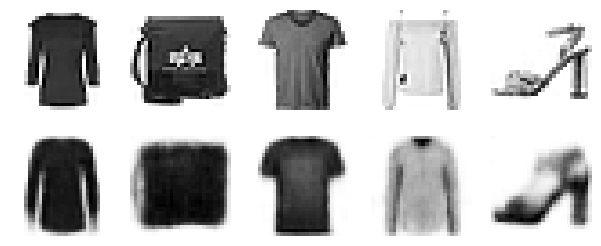

In [81]:
plot_reconstructions(variational_ae) # with conv
plt.show()

In [89]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

In [90]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

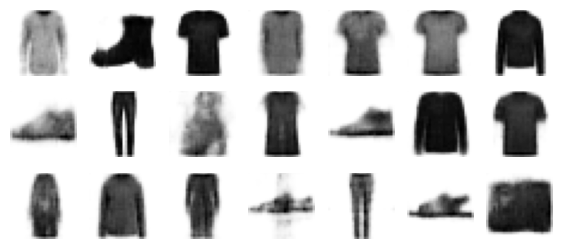

In [91]:
# extra code – this cells generates and saves Figure 17-12

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
save_fig("vae_generated_images_plot", tight_layout=False)
plt.show()

**Conv2D & MaxPooling2D & BatchNormalization**


In [101]:
inputs = tf.keras.layers.Input(shape=[28, 28, 1])
x = tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu", padding="same")(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu", padding="same")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
codings_mean = tf.keras.layers.Dense(codings_size)(x)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(x)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(7 * 7 * 64, activation="relu")(decoder_inputs)
x = tf.keras.layers.Reshape([7, 7, 64])(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = tf.keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, activation="sigmoid", padding="same")(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [102]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [103]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [104]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 15s 18ms/step - loss: 0.0502 - val_loss: 0.0406
Epoch 2/25
430/430 [==============================] - 6s 13ms/step - loss: 0.0362 - val_loss: 0.0353
Epoch 3/25
430/430 [==============================] - 6s 13ms/step - loss: 0.0345 - val_loss: 0.0342
Epoch 4/25
430/430 [==============================] - 6s 14ms/step - loss: 0.0336 - val_loss: 0.0337
Epoch 5/25
430/430 [==============================] - 7s 16ms/step - loss: 0.0330 - val_loss: 0.0328
Epoch 6/25
430/430 [==============================] - 6s 13ms/step - loss: 0.0327 - val_loss: 0.0325
Epoch 7/25
430/430 [==============================] - 6s 13ms/step - loss: 0.0324 - val_loss: 0.0323
Epoch 8/25
430/430 [==============================] - 6s 13ms/step - loss: 0.0322 - val_loss: 0.0323
Epoch 9/25
430/430 [==============================] - 6s 13ms/step - loss: 0.0320 - val_loss: 0.0317
Epoch 10/25
430/430 [==============================] - 6s 14ms/step - loss: 0.0319 - val_l

1/1 [==============================] - 0s 218ms/step


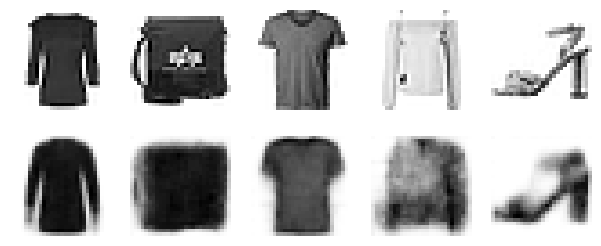

In [105]:
plot_reconstructions(variational_ae)
plt.show()

In [106]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

In [107]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

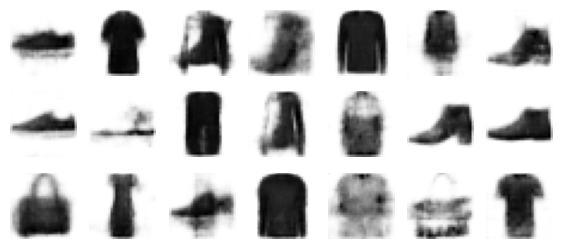

In [108]:
# extra code – this cells generates and saves Figure 17-12

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
save_fig("vae_generated_images_plot", tight_layout=False)
plt.show()

**Conv2D & BatchNormalization**

In [109]:
# Encoder
inputs = keras.layers.Input(shape=[28, 28, 1])
x = keras.layers.Conv2D(32, kernel_size=3, strides=2, padding="same")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation="relu")(x)
codings_mean = keras.layers.Dense(codings_size)(x)  # μ
codings_log_var = keras.layers.Dense(codings_size)(x)  # γ
codings = Sampling()([codings_mean, codings_log_var])
encoder = keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# Decoder
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(7 * 7 * 64, activation="relu")(decoder_inputs)
x = keras.layers.Reshape([7, 7, 64])(x)
x = keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation="relu", padding="same")(x)
x = keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, activation="sigmoid", padding="same")(x)
outputs = keras.layers.Reshape([28, 28])(x)
decoder_outputs = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [110]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [111]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [112]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 17s 16ms/step - loss: 0.0142 - val_loss: 0.0133
Epoch 2/25
430/430 [==============================] - 6s 14ms/step - loss: 0.0131 - val_loss: 0.0127
Epoch 3/25
430/430 [==============================] - 6s 14ms/step - loss: 0.0126 - val_loss: 0.0127
Epoch 4/25
430/430 [==============================] - 9s 20ms/step - loss: 0.0124 - val_loss: 0.0127
Epoch 5/25
430/430 [==============================] - 8s 18ms/step - loss: 0.0123 - val_loss: 0.0125
Epoch 6/25
430/430 [==============================] - 9s 20ms/step - loss: 0.0121 - val_loss: 0.0122
Epoch 7/25
430/430 [==============================] - 8s 18ms/step - loss: 0.0120 - val_loss: 0.0121
Epoch 8/25
430/430 [==============================] - 6s 14ms/step - loss: 0.0119 - val_loss: 0.0121
Epoch 9/25
430/430 [==============================] - 6s 13ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 10/25
430/430 [==============================] - 6s 14ms/step - loss: 0.0117 - val_l

1/1 [==============================] - 0s 449ms/step


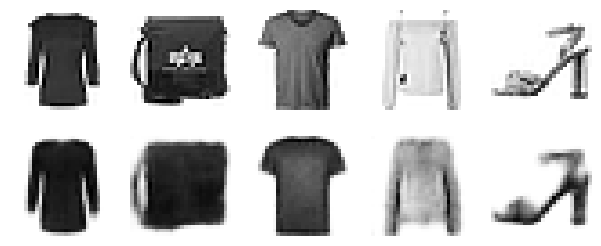

In [116]:
plot_reconstructions(variational_ae)
plt.show()

In [113]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

In [114]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

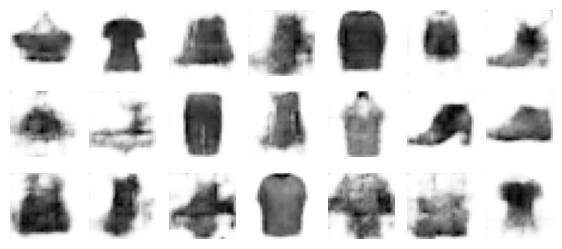

In [115]:
# extra code – this cells generates and saves Figure 17-12

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
save_fig("vae_generated_images_plot", tight_layout=False)
plt.show()

**Conv2D & kernel_size=6, strides=2**

In [117]:
# Encoder
inputs = keras.layers.Input(shape=[28, 28, 1])
x = keras.layers.Conv2D(32, kernel_size=6, strides=2, padding="same")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.Conv2D(64, kernel_size=6, strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation="relu")(x)
codings_mean = keras.layers.Dense(codings_size)(x)  # μ
codings_log_var = keras.layers.Dense(codings_size)(x)  # γ
codings = Sampling()([codings_mean, codings_log_var])
encoder = keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# Decoder
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(7 * 7 * 64, activation="relu")(decoder_inputs)
x = keras.layers.Reshape([7, 7, 64])(x)
x = keras.layers.Conv2DTranspose(32, kernel_size=6, strides=2, activation="relu", padding="same")(x)
x = keras.layers.Conv2DTranspose(1, kernel_size=6, strides=2, activation="sigmoid", padding="same")(x)
outputs = keras.layers.Reshape([28, 28])(x)
decoder_outputs = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [118]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [119]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [120]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 15s 15ms/step - loss: 0.0112 - val_loss: 0.0115
Epoch 2/25
430/430 [==============================] - 6s 14ms/step - loss: 0.0111 - val_loss: 0.0116
Epoch 3/25
430/430 [==============================] - 6s 14ms/step - loss: 0.0111 - val_loss: 0.0115
Epoch 4/25
430/430 [==============================] - 6s 13ms/step - loss: 0.0111 - val_loss: 0.0116
Epoch 5/25
430/430 [==============================] - 6s 15ms/step - loss: 0.0111 - val_loss: 0.0117
Epoch 6/25
430/430 [==============================] - 6s 13ms/step - loss: 0.0111 - val_loss: 0.0116
Epoch 7/25
430/430 [==============================] - 6s 14ms/step - loss: 0.0110 - val_loss: 0.0116
Epoch 8/25
430/430 [==============================] - 6s 13ms/step - loss: 0.0110 - val_loss: 0.0115
Epoch 9/25
430/430 [==============================] - 7s 16ms/step - loss: 0.0110 - val_loss: 0.0115
Epoch 10/25
430/430 [==============================] - 6s 13ms/step - loss: 0.0110 - val_l

1/1 [==============================] - 0s 229ms/step


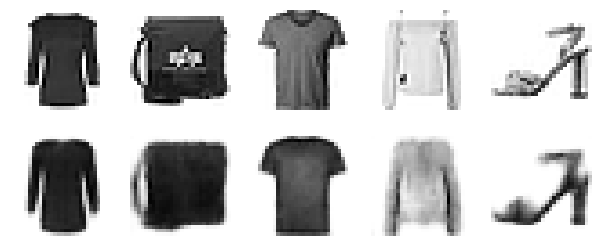

In [121]:
plot_reconstructions(variational_ae)
plt.show()

In [122]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

In [123]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

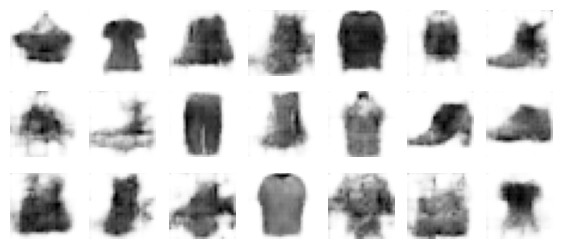

In [124]:
# extra code – this cells generates and saves Figure 17-12

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
save_fig("vae_generated_images_plot", tight_layout=False)
plt.show()

**Conv2D & LeakyReLU & kernel_size=6, strides=2**

In [126]:
# Encoder
inputs = keras.layers.Input(shape=[28, 28, 1])
x = keras.layers.Conv2D(32, kernel_size=6, strides=2, padding="same")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(keras.layers.LeakyReLU(0.2))(x)
x = keras.layers.Conv2D(64, kernel_size=6, strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(keras.layers.LeakyReLU(0.2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation=keras.layers.LeakyReLU(0.2))(x)
codings_mean = keras.layers.Dense(codings_size)(x)  # μ
codings_log_var = keras.layers.Dense(codings_size)(x)  # γ
codings = Sampling()([codings_mean, codings_log_var])
encoder = keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# Decoder
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(7 * 7 * 64, activation=keras.layers.LeakyReLU(0.2))(decoder_inputs)
x = keras.layers.Reshape([7, 7, 64])(x)
x = keras.layers.Conv2DTranspose(32, kernel_size=6, strides=2, activation=keras.layers.LeakyReLU(0.2), padding="same")(x)
x = keras.layers.Conv2DTranspose(1, kernel_size=6, strides=2, activation="sigmoid", padding="same")(x)
outputs = keras.layers.Reshape([28, 28])(x)
decoder_outputs = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [127]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [128]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [130]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=5, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/5
430/430 [==============================] - 18s 16ms/step - loss: 0.0106 - val_loss: 0.0113
Epoch 2/5
430/430 [==============================] - 6s 14ms/step - loss: 0.0106 - val_loss: 0.0113
Epoch 3/5
430/430 [==============================] - 6s 14ms/step - loss: 0.0106 - val_loss: 0.0113
Epoch 4/5
430/430 [==============================] - 6s 14ms/step - loss: 0.0106 - val_loss: 0.0113
Epoch 5/5
430/430 [==============================] - 6s 14ms/step - loss: 0.0106 - val_loss: 0.0114


1/1 [==============================] - 0s 249ms/step


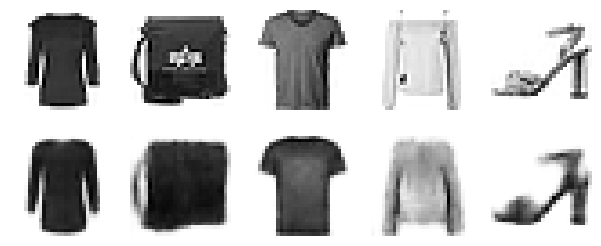

In [131]:
plot_reconstructions(variational_ae)
plt.show()

In [132]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

In [133]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

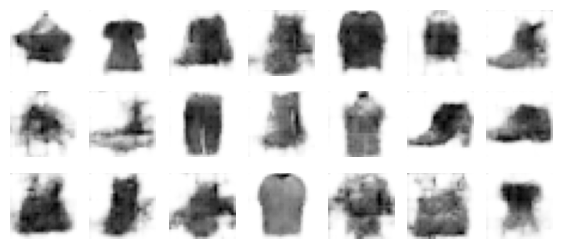

In [134]:
# extra code – this cells generates and saves Figure 17-12

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
save_fig("vae_generated_images_plot", tight_layout=False)
plt.show()